In [42]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

rng_seed = 24

# Configure input data

In [43]:
tracks = pd.read_csv("data/processed/tracks.csv")

In [44]:
X = tracks.drop(['popularity'], axis=1)
y = tracks['popularity']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng_seed)
X_train = torch.tensor(X_train.values).float()
X_test = torch.tensor(X_test.values).float()
y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()

In [46]:
batch_size = 32

In [47]:
train = data_utils.TensorDataset(X_train, y_train)
train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

# Setup neural network

In [48]:
class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.layers(x)
    
    def predict(self, x):
        return torch.round(self.layers(x).detach())

# Root mean squared error loss

In [49]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

# Training

In [63]:
torch.manual_seed(rng_seed)

input_size = X_train.shape[1]
hidden_size = 100
output_size = 1
fnn = FNN(input_size, hidden_size, output_size)

loss_fn = RMSELoss()
lr = 0.01
optimizer = torch.optim.Adam(fnn.parameters(), lr=lr)

training_losses = []
val_losses = []
r2_scores = []

num_epochs = 100

# Run the training loop
for epoch in range(num_epochs):
    print(f"{'=' * 5} Epoch {epoch} {'=' * 5}")
    
    current_losses = []
    
    for i, data in enumerate(train_loader):        
        # Get and prepare inputs
        inputs, targets = data
        targets = targets.unsqueeze(dim=-1)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = fnn(inputs)
        
        # Compute loss
        loss = loss_fn(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Training loss
        current_losses.append(loss.item())
        
    # Average training loss of the batches in this epoch
    training_losses.append(np.mean(current_losses))
    
    # Validation loss
    with torch.no_grad():
        val_pred = fnn.predict(X_test)
        val_loss = loss_fn(val_pred, y_test.unsqueeze(dim=-1))
        val_losses.append(val_loss.item())
        r2_scores.append(r2_score(y_test, val_pred))
        
    print(f"Training loss: {round(training_losses[-1], 3)}, Validation Loss: {round(val_losses[-1], 3)}, R2 Score: {round(r2_scores[-1], 3)}")
    
print('\nTraining process has finished.')

===== Epoch 0 =====
Training loss: 14.597, Validation Loss: 13.983, R2 Score: 0.426
===== Epoch 1 =====
Training loss: 13.811, Validation Loss: 13.763, R2 Score: 0.444
===== Epoch 2 =====
Training loss: 13.669, Validation Loss: 13.642, R2 Score: 0.454
===== Epoch 3 =====
Training loss: 13.628, Validation Loss: 13.939, R2 Score: 0.43
===== Epoch 4 =====
Training loss: 13.584, Validation Loss: 13.788, R2 Score: 0.442
===== Epoch 5 =====
Training loss: 13.562, Validation Loss: 13.602, R2 Score: 0.457
===== Epoch 6 =====
Training loss: 13.541, Validation Loss: 13.609, R2 Score: 0.457
===== Epoch 7 =====
Training loss: 13.517, Validation Loss: 13.721, R2 Score: 0.448
===== Epoch 8 =====
Training loss: 13.472, Validation Loss: 13.526, R2 Score: 0.463
===== Epoch 9 =====
Training loss: 13.43, Validation Loss: 13.627, R2 Score: 0.455
===== Epoch 10 =====
Training loss: 13.393, Validation Loss: 13.474, R2 Score: 0.467
===== Epoch 11 =====
Training loss: 13.352, Validation Loss: 13.455, R2 Score

Training loss: 12.503, Validation Loss: 12.677, R2 Score: 0.528
===== Epoch 98 =====
Training loss: 12.533, Validation Loss: 12.684, R2 Score: 0.528
===== Epoch 99 =====
Training loss: 12.53, Validation Loss: 12.844, R2 Score: 0.516

Training process has finished.


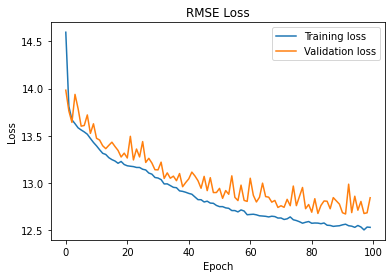

In [65]:
plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"RMSE Loss")
plt.legend()

Text(0.5, 1.0, 'R2 Score')

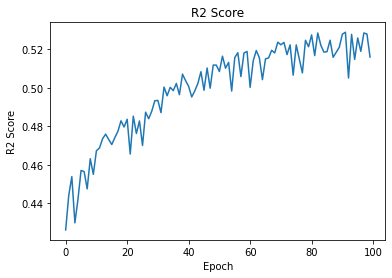

In [66]:
plt.plot(r2_scores)
plt.xlabel("Epoch")
plt.ylabel("R2 Score")
plt.title("R2 Score")